In [11]:
#run imports
import torch, time, Data, random, sys, json
import matplotlib.pyplot as plt
import torch.nn as nn
from tokenizer import Tokenizer
torch.random.manual_seed(1)

#choose device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f'Device set to {device}')

Device set to cpu


In [ ]:
# Model hyper parameters
chunk_size = 128
embedding_dim = 256 #must be some factor of heads in attention layers

# Transforer Hyper parameters
num_attention_blocks = 4
num_heads = 8
dropout_rate = 0.0

# Training parameters
batch_size = 32
learning_rate = 0.001
train_time = 60 # minutes
num_step=15000

vocab_file = 'vocab_chars.json'

In [ ]:
#get data
train_file='tbbt_train.txt'
test_file='tbbt_test.txt'

file = open(vocab_file, 'r')
vocab = json.loads(file.read())
file.close()

tokenizer = Tokenizer(vocab)

data = Data.Data(train_file, test_file, tokenizer, chunk_size, sample_data=True)

#sample data
x, y = data.get_train_sample(index=0, num_samples = 1)
print(x)
print(y)
print(f'X: {x.shape}, Y: {y.shape}')
print('X: (batch size, chunk size), Y: (batch size, chunk size, num char)')

character list:
	['\n', ' ', '!', '$', '%', '&', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

tensor([[ 0, 25, 33, 44, 37, 47, 43, 32, 33, 27,  0, 47, 31, 33, 42, 33, 23,  1,
          1, 29,  1, 31, 43, 46, 46, 37, 32, 43, 46,  1, 29, 48,  1, 29,  1, 47,
         44, 33, 46, 41,  1, 30, 29, 42, 39, 11,  0,  0, 47, 36, 33, 40, 32, 43,
         42, 23,  1,  1, 47, 43,  1, 37, 34,  1, 29,  1, 44, 36, 43, 48, 43, 42,
          1, 37, 47,  1, 32, 37, 46, 33, 31, 48, 33, 32,  1, 48, 36, 46, 43, 49,
         35, 36,  1, 29,  1, 44, 40, 29, 42, 33,  1, 51, 37, 48, 36,  1, 48, 51,
         43,  1, 47, 40, 37, 48, 47,  1, 37, 42,  1, 37, 48,  1, 29, 42, 32,  1,
         33, 37]])
tensor([[25, 33, 44, 37, 47, 43, 32, 33, 27,  0, 47, 31, 33, 42, 33, 23,  1,  1,
         29,  1, 31, 43, 46, 46, 37, 3

In [14]:
#Transformer network implementation
class self_attention_head(nn.Module):
    def __init__(self, head_size=16):
        super().__init__()
        B, T, C = batch_size, chunk_size, embedding_dim
        #B = the number of samples in each batch (Batch Size: chunk_size)
        #T = the number of items in the time dependant series, (number of characters: num_char)
        #C = the number of channels in each time stamp (embedding dimension of time stamp: embedding_dim)
        self.head_size = head_size
        
        #key and query layers
        self.key = nn.Linear(C, head_size, bias = False)
        self.query = nn.Linear(C, head_size, bias = False)
        self.value = nn.Linear(C, head_size, bias = False)
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        #X = (B, T, C)
        B, T, C = x.shape

        #Get Keys and Qeuries
        k = self.key(x) #(B, T, head Size)
        q = self.query(x) #(B, T, head Size)

        #get averaged weight matrix
        #weights = q @ k.transpose(-2, -1) * C ** -0.5 # (B,T,head_size) @ (B,head_size,T) = (B,T,T)
        scale = self.head_size ** -0.5
        weights = q @ k.transpose(-2, -1) * scale
        weights = weights.masked_fill(self.tril == 0, float('-inf')) # optional, when eneabled, it prevents past nodes from accessing future nodes, EX w,o,r,d char w wont have info about o
        weights = nn.functional.softmax(weights, dim= -1)
        weights = self.dropout(weights)

        #get output
        v = self.value(x)
        out = weights @ v

        return out

class multi_head_attention(nn.Module):
    def __init__(self, num_heads, head_size=16):
        super().__init__()
        
        if num_heads * head_size != embedding_dim:
            raise ValueError("num_heads * head_size must equal embedding_dim")

        self.heads = nn.ModuleList([self_attention_head(head_size=head_size) for i in range(num_heads)])
        self.proj = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class Attention_Block(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.head_size = embedding_dim // num_heads
        if self.head_size * num_heads != embedding_dim:
            raise ValueError("embedding dimenstion needs to be divisible by number of heads")
        self.attention = multi_head_attention(num_heads, head_size=self.head_size)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        #feed forward section
        self.ffw = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.ReLU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(dropout_rate)
        )
    
    def forward(self, x):
        x = x + self.attention(self.layer_norm1(x))
        x = x + self.ffw(self.layer_norm2(x))
        return x

#want an output of B, embedding dim
B, T, C = batch_size, chunk_size, embedding_dim
x= torch.randn(B,T,C).to(device)
attention_head=Attention_Block(embedding_dim, 4).to(device)
out = attention_head.forward(x)
out.shape

torch.Size([32, 128, 256])

In [15]:
# Define the neural network model
class Brain(nn.Module):
    def __init__(self):
        super(Brain, self).__init__()

        self.char_emb = nn.Embedding(len(tokenizer.vocab_list), embedding_dim)
        self.pos_emb = nn.Embedding(chunk_size, embedding_dim)

        #attention layers
        self.attention_blocks = nn.Sequential(*[Attention_Block(embedding_dim, num_heads) for i in range(num_attention_blocks)])
        self.layer_norm = nn.LayerNorm(embedding_dim)

        #Layers
        self.fc1 = nn.Linear(embedding_dim, len(tokenizer.vocab_list))

        #better weight initialization
        self.apply(self._init_weights)

        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer= torch.optim.AdamW(self.parameters(), lr=learning_rate)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets= None):
        #run through embedding layer
        B, T = x.size()
        C = len(tokenizer.vocab_list)
        
        char_emb = self.char_emb(x)
        pos_emb = self.pos_emb(torch.arange(chunk_size, device=device))
        x = char_emb + pos_emb

        x = self.attention_blocks(x)
        x = self.layer_norm(x)
        #x = x.view((-1, chunk_size * embedding_dim))

        #run through reshaping layer and softmax
        logits = self.fc1(x)

        if targets is None:
            #logits = self.softmax(output)
            return logits
        else:
            #print(logits.size())
            logits_flat  = logits.view(B * T, C)     # (64*32, 55)
            targets_flat = targets.view(B * T)       # (64*32)
            #print(logits_flat.size(),targets_flat.size())
            loss = self.loss_func(logits_flat, targets_flat)
            
            # logits = logits.view(batch_size, -1)
            # print(logits.size(), targets.size())
            # loss = self.loss_func(logits, targets)
            # print(loss.item())
            return logits, loss
        
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -chunk_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            log_probs = nn.functional.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(log_probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# Create the model
model = Brain()
model.to(device)

print(sum(p.numel() for p in model.parameters())/1E6, 'Million Parameters')

cost_data, cost_it=[],[]
step=0

3.217463 Million Parameters


In [16]:
#load saved checkpoint
# checkpoint_state = torch.load('Checkpoint.pth.tar')
# model.load_state_dict(checkpoint_state['state_dict'])
# optimizer.load_state_dict(checkpoint_state['optimizer'])
# cost_data = checkpoint_state['loss']

In [ ]:
# Train Model
model.train()
start=time.time()

flatten_const=100

while(time.time()-start<60*train_time):
    step+=1
    #for step in range(num_step):
    index = random.randint(0, len(data.train_text) - data.ctx_size - 1 - batch_size)
    x_train, y_train= data.get_train_sample(index, batch_size)
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    # Forward pass
    outputs, loss = model(x_train, y_train)

    # Backward and optimize
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()

    cost_it.append(loss.item())


    #flatten graph data
    if (step + 1) % flatten_const == 0:
        cost_data.append(torch.tensor(cost_it).mean().item())
        cost_it=[]

    #print update
    if (step + 1) % 100 == 0:
        print(f"Step [{step+1}], Loss: {cost_data[-1]:.4f}")

    if (step + 1) % 5000 == 0:
        state = {'state_dict':model.state_dict(), 'optimizer':model.optimizer.state_dict(), 'loss':cost_data}
        torch.save(state, 'Checkpoint.pth.tar')
        print('Saved Checkpoint')

print(step)

torch.cuda.empty_cache()

Step [50500], Loss: 1.2077
Step [50600], Loss: 1.2518
Step [50700], Loss: 1.2435
Step [50800], Loss: 1.2429
Step [50900], Loss: 1.2015
Step [51000], Loss: 1.2204
Step [51100], Loss: 1.2046
Step [51200], Loss: 1.1916
Step [51300], Loss: 1.2099
Step [51400], Loss: 1.1915
Step [51500], Loss: 1.2054
Step [51600], Loss: 1.1991
Step [51700], Loss: 1.2163
Step [51800], Loss: 1.2673
Step [51900], Loss: 1.2380
Step [52000], Loss: 1.1961
Step [52100], Loss: 1.2013
Step [52200], Loss: 1.1958
Step [52300], Loss: 1.1956
Step [52400], Loss: 1.2010
Step [52500], Loss: 1.1950
Step [52600], Loss: 1.2187
Step [52700], Loss: 1.1995
Step [52800], Loss: 1.2076
Step [52900], Loss: 1.2178
Step [53000], Loss: 1.1901
Step [53100], Loss: 1.2010
Step [53200], Loss: 1.2322
Step [53300], Loss: 1.1608
Step [53400], Loss: 1.1824
Step [53500], Loss: 1.2027
Step [53600], Loss: 1.1849
Step [53700], Loss: 1.2220
Step [53800], Loss: 1.2084
Step [53900], Loss: 1.2060
Step [54000], Loss: 1.1800
Step [54100], Loss: 1.2098
S

KeyboardInterrupt: 

In [89]:
# Run test set
model.eval()
test_loss_list=[]
test_batch_size=2000
start = time.time()
with torch.no_grad():
    for i in range((len(data.test_text)-len(tokenizer.vocab_list)-1)//test_batch_size):
        x, y = data.get_test_sample(i*test_batch_size, test_batch_size)
        x=x.to(device)
        y=y.to(device)
        outputs, loss = model(x, y)
        test_loss_list.append(loss)

        torch.cuda.empty_cache()
        print(f'Step [{i}/{(len(data.test_text)-len(tokenizer.vocab_list))//test_batch_size}, Loss: {loss.item()}]')
val_loss=torch.tensor(test_loss_list).mean().item()
print(f'Validation Loss: {val_loss}, Test Time: {time.time() - start}')

torch.cuda.empty_cache()

Step [0/362, Loss: 1.1128332614898682]
Step [1/362, Loss: 1.1247279644012451]
Step [2/362, Loss: 1.110111951828003]
Step [3/362, Loss: 1.0498850345611572]
Step [4/362, Loss: 1.1062884330749512]
Step [5/362, Loss: 1.128397822380066]
Step [6/362, Loss: 1.185092806816101]
Step [7/362, Loss: 1.093511700630188]
Step [8/362, Loss: 1.1483087539672852]
Step [9/362, Loss: 1.3549158573150635]
Step [10/362, Loss: 1.1504334211349487]
Step [11/362, Loss: 1.1783664226531982]
Step [12/362, Loss: 1.143185019493103]
Step [13/362, Loss: 1.216731309890747]
Step [14/362, Loss: 1.2527354955673218]
Step [15/362, Loss: 1.3713186979293823]
Step [16/362, Loss: 1.1141513586044312]
Step [17/362, Loss: 1.169584035873413]
Step [18/362, Loss: 1.3963414430618286]
Step [19/362, Loss: 1.2054692506790161]
Step [20/362, Loss: 1.145362138748169]
Step [21/362, Loss: 1.1534744501113892]
Step [22/362, Loss: 1.142699122428894]
Step [23/362, Loss: 1.2082562446594238]
Step [24/362, Loss: 1.2678192853927612]
Step [25/362, Loss:

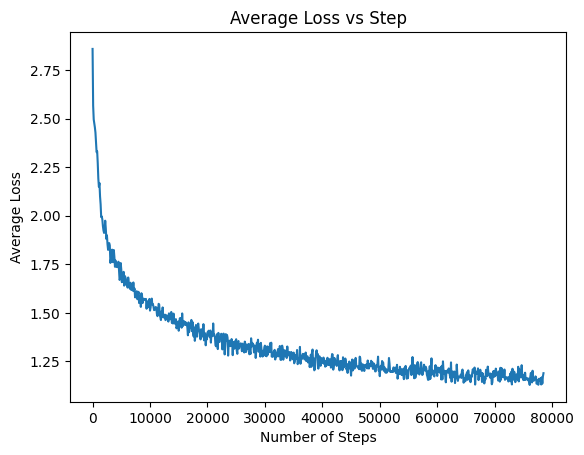

In [ ]:
# Plot training data
plt.plot(torch.arange(0, len(cost_data))*flatten_const, cost_data)
plt.xlabel('Number of Steps')
plt.ylabel('Average Loss')
plt.title('Average Loss vs Step')
plt.show()

In [ ]:
# LLM Inference

def sample_with_temp(probs, temperature=1.0, top_k=None):
    # Apply temperature scaling
    if temperature != 1.0:
        probs = probs ** (1.0 / temperature)
    probs = probs / probs.sum()  # Re-normalize

    if top_k is not None:
        # Get top-k probabilities and their indices
        top_probs, top_indices = torch.topk(probs, top_k)
        top_probs = top_probs / top_probs.sum()
        sampled_index = torch.multinomial(top_probs, num_samples=1)
        return top_indices[sampled_index].item()
    else:
        return torch.multinomial(probs, num_samples=1).item()

# Begin generation
model.eval()
tokens = data._encoded_train_data[-data.ctx_size:]
text = data.train_text[0:data.ctx_size]
print('"', end='', sep='')

total_log_prob = 0.0
n_tokens = 0

# Sampling config
TEMPERATURE = 0.8
TOP_K = 40

with torch.no_grad():
    for i in range(5000):
        # Generate input
        x = torch.tensor(tokens[-data.ctx_size:]).to(device)
        x = x.reshape((1, data.ctx_size))

        # Model forward
        output = model(x)  # shape: (1, T, vocab_size)
        output = output.view((chunk_size, len(tokenizer.vocab_list)))  # Flattening, okay here
        logits = output[-1]  # Last token's prediction

        # Convert to probabilities
        probs = nn.functional.softmax(logits, dim=-1)

        # Sample a token
        #sampled_token = torch.multinomial(probs, num_samples=1).item()
        sampled_token = sample_with_temp(probs, temperature=TEMPERATURE, top_k=TOP_K)
        tokens.append(sampled_token)

        # Track log probability
        log_prob = torch.log(probs[sampled_token])
        total_log_prob += log_prob.item()
        n_tokens += 1

        # Decode and print
        char = tokenizer.decode([sampled_token])[0]
        text += char
        print(char, end='', sep='')
        sys.stdout.flush()

print('"\n', sep='')

# Compute and print perplexity
import math
perplexity = math.exp(-total_log_prob / n_tokens)
print(f"[Perplexity of generated text: {perplexity:.3f}]")


"
<episode>
scene:  pennys apartment.

leonard:  hair until he on the cheese is been and got you tried on the point, and i was mad having it for her for warries.

penny:  i flant matter. and this is mad. i never can draw him she last bange it is a little in diaser others like, and i used to worry with you. priya didnt to call.

sheldon:  oh, good look. and one shamy liwy cheese and extrated, not lie of its only or.

penny:  hey, its not comped.

sheldon:  its okay.

penny:  why do i be worried into the authing computes?

sheldon:  ill see you out each for the mandaleagual is as president the stutence of by head. im trouble, go people has talking about his baod-neodled slow dishermo.

penny:  im not your friend.

leonard:  i was dested.

sheldon:  esweet, ill take you to live up. we can nice who had matterable. how is in the way the laberrie, and his turn of gring leonard has of a proble knight years but the comic books are every elf, but i thought you as impled all webing the next more